This is a beginner script to Compare Upgrade MC data (Queso) to low energy DeepCore data (Greco)

Queso file were prior converted vom .i3 to .npy using https://github.com/mjlarson/nusources_dataset_converters/tree/main

In [102]:
import os, sys, glob
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
from scipy.integrate import simps
import histlite as hl

# Readin

<font color='red'>Question:</font> only the tau dataset is available for Queso. In Greco it is already merged (tau + taubar)? Is this a problem since some properties are calculated with all flavors?

Also how do we know if this is NC and/or CC?

In [104]:
queso_e_only = np.load("ConvertedQuesoFiles/upgrade_queso_120028.npy")
queso_ebar_only = np.load("ConvertedQuesoFiles/upgrade_queso_121028.npy")
queso_mu_only = np.load("ConvertedQuesoFiles/upgrade_queso_140028.npy")
queso_mubar_only = np.load("ConvertedQuesoFiles/upgrade_queso_141028.npy")
queso_tau = np.load("ConvertedQuesoFiles/upgrade_queso_160028.npy")

queso_e = np.concatenate([queso_e_only, queso_ebar_only])
queso_mu = np.concatenate([queso_mu_only, queso_mubar_only])
queso_all = np.concatenate([queso_e, queso_mu, queso_tau])

greco_e  = np.load("/data/ana/analyses/greco_online/version-002-p12/IC86_2012.nue_merged.npy")
greco_mu = np.load("/data/ana/analyses/greco_online/version-002-p12/IC86_2012.numu_merged.npy")
greco_tau= np.load("/data/ana/analyses/greco_online/version-002-p12/IC86_2012.nutau_merged.npy")

greco_all = np.concatenate([greco_e, greco_mu, greco_tau])


plotfolder = 'Comparison/'
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

# Effective area

recipy: 
1) use electron, muon, tau datasets separately (combined nu nubar)
2) use trueE for energy
3) <font color='red'>Question:</font> use x['ow'][mask] * x['trueE'][mask]**(-2.5) for weights or just one-weights? Gut feeling is just one-weights but that is not consistant
4) calculate effective area per energy bin for given declinations per neutrino flavor

calculating the effective area was taken from Michael's code

https://github.com/mjlarson/effective_area_example/blob/main/aeff_plot.ipynb

In [6]:
def make_aeff(ax, x, 
              ebins = np.logspace(0, 5, 101), 
              dec_min = -np.pi/2.,
              dec_max = np.pi/2.,
              **kwargs):

    # Mask the events to the correct range of declinations and
    # histogram the 'oneweight' values. This will give us a histogram
    # in the same units as 'ow', which means we'll have `GeV cm2 sr`
    # after this step.
    mask = (dec_min <= x['trueDec']) & (x['trueDec'] <= dec_max)
    h, b = np.histogram(x['trueE'][mask],
                        weights = x['ow'][mask],# * x['trueE'][mask]**(-2.5),
                        bins=ebins)

    # Now account for the phase space, which will reduce us from
    # `GeV cm2 sr` to `cm2`
    h /= np.diff(b)
    h /= 2*np.pi
    h /= (np.sin(x['trueDec'].max()) - np.sin(x['trueDec'].min()))
    
    # And now we're finally at an effective area curve!
    # It's currently in cm^2. Convert it to m^2
    h /= 1e4 

    # Now plot it onto the axis and return.
    _ = ax.hist(b[:-1],
                bins = b,
                weights = h,
                **kwargs)
    return

def GeneratePlot(ebins,dec_bins,Quesodata,Grecodata,nametag):
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    fig, ax = plt.subplots(figsize=(10,6))

    for c, (dmin, dmax) in zip(colors, zip(dec_bins[:-1], dec_bins[1:])):
        label = f"{np.degrees(dmin)} " + r"$\leq \delta <$" + f"{np.degrees(dmax)}"
        make_aeff(ax, Quesodata, ebins, 
                  dec_min = dmin,
                  dec_max = dmax,
                  histtype='step',
                  linewidth=3,
                  linestyle = 'solid',
                  color=c,
                  alpha=0.5,
                  label='Queso ' + label)
        
        
    for c, (dmin, dmax) in zip(colors, zip(dec_bins[:-1], dec_bins[1:])):
        label = f"{np.degrees(dmin)} " + r"$\leq \delta <$" + f"{np.degrees(dmax)}"
        make_aeff(ax, Grecodata, ebins, 
                  dec_min = dmin,
                  dec_max = dmax,
                  histtype='step',
                  linewidth=3,
                  linestyle='solid',
                  color=c,
                  alpha=1,
                  label='Greco ' + label)
    
    ax.grid(alpha=0.25)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='lower right', fontsize=14, framealpha = 1,)
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_xlabel("Neutrino Energy (GeV)", fontsize=16)
    ax.set_ylabel(r"$\nu_{%s}^{NC+CC}$ Effective Area (m$^2$)"%nametag, fontsize=16)
    fig.savefig(plotfolder + "1EffectiveArea_%s.pdf"%nametag.replace('\\', ""))


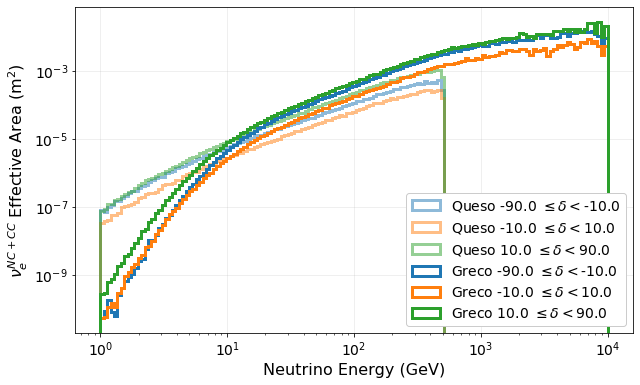

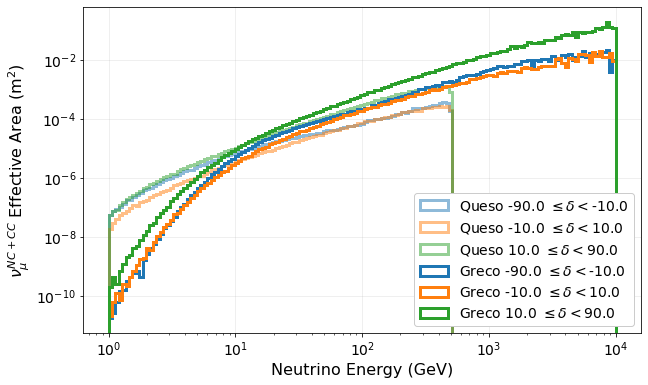

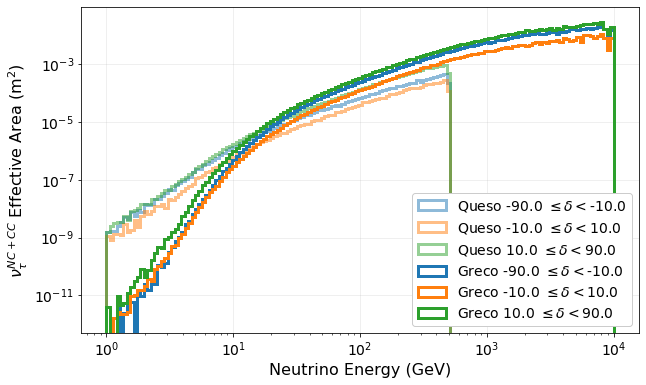

In [7]:
ebins = np.logspace(0, 4, 150)
dec_bins = np.radians([-90, -10, 10, 90])

GeneratePlot(ebins,dec_bins,queso_e,  greco_e,  r'e')
GeneratePlot(ebins,dec_bins,queso_mu, greco_mu, r'\mu')
GeneratePlot(ebins,dec_bins,queso_tau,greco_tau,r'\tau')
#GeneratePlot(ebins,dec_bins,queso_all,greco_all,r'all')

### expected neutrino rate

not needed but I was curious (and maybe did it wrong)

In [9]:
def calculateNeutrinoRate(data):
    dec_min = -np.pi/2,
    dec_max = np.pi/2,

    # Mask the events to the correct range of declinations and histogram the 'oneweight' values
    mask = (dec_min <= data['trueDec']) & (data['trueDec'] <= dec_max)
    h, b = np.histogram(data['trueE'][mask], weights=data['ow'][mask], bins=ebins)
    
    
    # Calculate the bin centers
    energy_centers = 0.5 * (b[1:] + b[:-1])
    
    # Account for the phase space
    h /= np.diff(b)
    h /= 2 * np.pi
    h /= (np.sin(data['trueDec'].max()) - np.sin(data['trueDec'].min()))
    
    # Convert to effective area in m^2
    effective_area = h / 1e4
    
    # Flux as a function of energy (E^-2.5) at bin centers
    flux = energy_centers**(-2.5)
    
    # Calculate the integrand
    integrand = effective_area * flux
    
    # Perform the numerical integration
    rate = simps(integrand, energy_centers)
    
    # Conversion factor from seconds to years
    sec_to_year = 365.25 * 24 * 60 * 60
    
    # Convert rate to events per year
    rate_per_year = rate * sec_to_year

    return rate_per_year

ebins = np.logspace(1, np.log10(max(queso_all['trueE'])), 150)
rate_per_year_queso = calculateNeutrinoRate(queso_all)
rate_per_year_greco = calculateNeutrinoRate(greco_all)

print(f'Expected neutrino rate for all declinations from {min(ebins)} to {np.round(max(ebins))} GeV')
print(f"Queso: {rate_per_year_queso:.2f} events per year")
print(f"Greco: {rate_per_year_greco:.2f} events per year")

Expected neutrino rate for all declinations from 10.0 to 500.0 GeV
Queso: 134.92 events per year
Greco: 297.28 events per year


# Resolution

recipy:
1) use trueRa, trueDec, ra, dec.
2) Reconstruted angular distance sigma (queso) / angErr (greco) not needed for resolution but we have a <font color='red'>Question:</font> are these the same? angErr does not exist from the converted queso files and looks like the conversion is done for it.
3) calculate true angular distance: arccos(...)
4) using true energy and true angular distance, calculate the resolution per energy bin

## Angular distance

In [10]:
def CalculateTrueAngularDistance(data):

    true_ra = data['trueRa']
    true_dec = data['trueDec']
    reco_ra = data['ra']
    reco_dec = data['dec']

    
    '''Calculates angular distance between two points. Units must be given in radians'''
    # Calculate the cosine of the angle (in radians)
    cos_angle = np.sin(true_ra) * np.sin(reco_ra) + np.cos(true_ra) * np.cos(reco_ra) * np.cos(reco_dec - true_dec)

    # Ensure the cosine value is valid
    cos_angle = np.clip(cos_angle, -1.0, 1.0)

    # Calculate the angle (in radians)
    angle_rad = np.arccos(cos_angle)
    return angle_rad

def PlotAngularDistance(true_angular_distance,reco_angular_distance,weighting,tag):
    '''Plots a 2D histogram of true and reconstructed angular distance'''
    binning=np.logspace(0,3,20)
    
    ax = plt.figure(figsize=(5,3.5))
    h = plt.hist2d(np.degrees(true_angular_distance), np.degrees(reco_angular_distance), bins=binning, cmap='Blues', weights=weighting)#, norm=LogNorm())
    cbar = plt.colorbar(h[3],  label=r'ow $\cdot$ $E_{true}^{-2.5}$')#, norm=LogNorm())
    
    #add information
    plt.xlabel('True angular distance (deg)')
    plt.ylabel('Reconstructed angular distance (deg)')
    plt.title(tag)
    
    #axis
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(10**-1,10**2)
    plt.ylim(10**-1,10**2)
    plt.plot([0, 500], [0, 500], c='black')
    plt.grid(lw=0.75,ls='--',alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(plotfolder+"2AngularDistances_%s.pdf"%tag)
    plt.show()
    

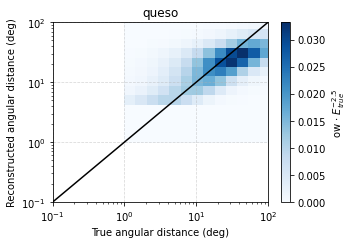

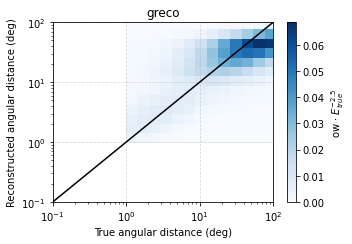

In [11]:
#Queso
data = queso_all
reco_angular_distance = data['sigma']
true_angular_distance = CalculateTrueAngularDistance(data)
weights = data['ow'] * data['trueE']**(-2.5)

PlotAngularDistance(true_angular_distance, reco_angular_distance, weights,'queso')

#Greco
data = greco_all
reco_angular_distance = data['angErr']
true_angular_distance = CalculateTrueAngularDistance(data)
weights = data['ow'] * data['trueE']**(-2.5)

PlotAngularDistance(true_angular_distance, reco_angular_distance, weights,'greco')

## Resolution

this code was modified from cskys tutorial page: https://software.icecube.wisc.edu/csky/main/misc_plotting.html

In [105]:
def ResolutionVsTrueEnergy(data,logEbins,tag):
    #grab data
    true_angular_distance = CalculateTrueAngularDistance(data)
    true_energy = data["trueE"]
    weights = data['ow'] * data['trueE']**(-2.5)
    
    # create a histogram:
    h = hl.hist_slide(
        # slide the bins 5 times along energy, hold them still along angular error
        (5,1),
        # 2D histogram of true energy and angular error in degrees
        (true_energy, np.degrees(true_angular_distance)),
        # E^-2.5 weighting
        weights,
        # from 1 GeV to 1 TeV, plus a bit so there are bins at the endpoints
        bins=(10**logEbins, np.r_[0:180.01:.5])
    )
    
    # normalize along the angular error axis
    h = h.normalize(1)
    # get 20%, 50%, and 80% quantiles
    h2 = h.contain(1, .2)
    h5 = h.contain(1, .5)
    h8 = h.contain(1, .8)

    
    #plot results
    soft_colors = ['#004466', '#d06050', '#2aca80', '#dd9388', '#caca68']
    
    fig, ax = plt.subplots()
    
    # plot quantiles, emphasize median
    color = soft_colors[0]
    hl.fill_between(ax, 0, h2, color=color, alpha=.3, drawstyle='line')
    hl.fill_between(ax, 0, h5, color=color, alpha=.3, drawstyle='line')
    hl.fill_between(ax, 0, h8, color=color, alpha=.3, drawstyle='line')
    hl.plot1d (ax, h5, color=color, lw=2, drawstyle='default')
    
    # trick to get the legend handles colored right
    # try testing what happens if you just do hl.fill_between(..., label='...')
    nans = [np.nan, np.nan]
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**1, label='80%')
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**2, label='50%')
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**3, label='20%')
    
    # labels etc
    ax.semilogx()
    ax.set_xlabel(r'$E_\mathrm{true}$ (GeV)')
    ax.set_ylabel(r'$\Delta\Psi[\mathrm{true,reco}]~(deg)$')
    ax.set_xlim(h.bins[0][1], h.bins[0][-2])
    ax.set_ylim(0)
    ax.legend(loc='upper right')
    plt.title(tag)


    plt.xlim(2,475) #cuts off greco's higher energies consistent layout
    plt.ylim(0,125)
    
    plt.tight_layout()
    plt.savefig(plotfolder + '2Resolution_%s.pdf'%tag)


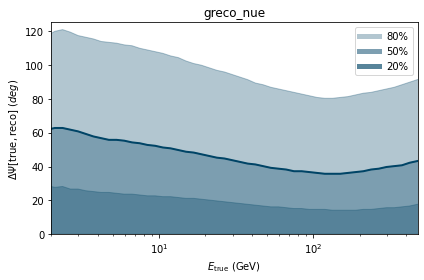

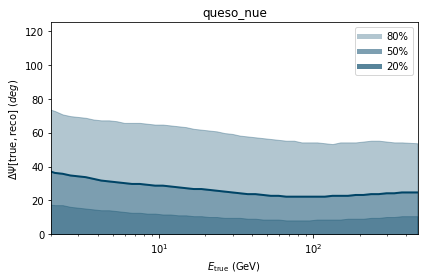

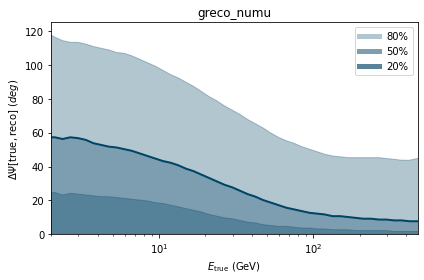

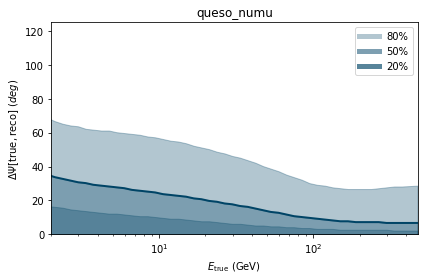

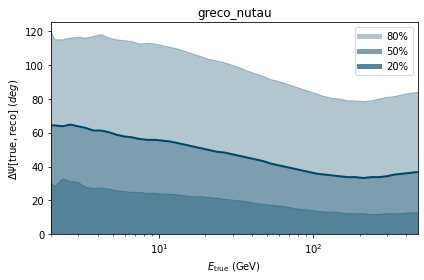

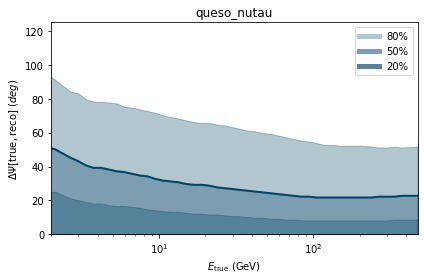

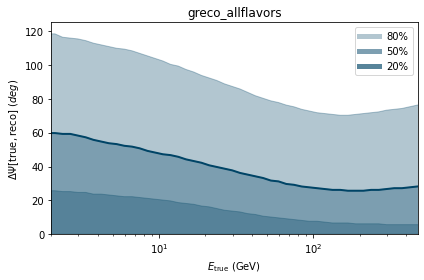

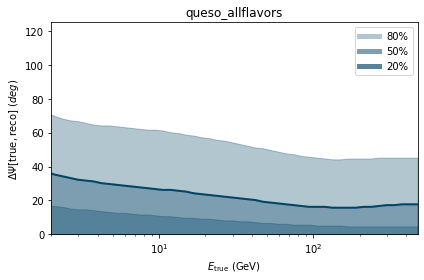

In [106]:
ResolutionVsTrueEnergy(greco_e,np.r_[0:4.01:.25],'greco_nue')
ResolutionVsTrueEnergy(queso_e,np.r_[0:2.76:.25],'queso_nue')
ResolutionVsTrueEnergy(greco_mu,np.r_[0:4.01:.25],'greco_numu')
ResolutionVsTrueEnergy(queso_mu,np.r_[0:2.76:.25],'queso_numu')
ResolutionVsTrueEnergy(greco_tau,np.r_[0:4.01:.25],'greco_nutau')
ResolutionVsTrueEnergy(queso_tau,np.r_[0:2.76:.25],'queso_nutau')
ResolutionVsTrueEnergy(greco_all,np.r_[0:4.01:.25],'greco_allflavors')
ResolutionVsTrueEnergy(queso_all,np.r_[0:2.76:.25],'queso_allflavors')

# Background rates

For Queso files we have the atmospheric weight as a background rate.

For Greco files we need to estimate it from a GRL. The detector is background dominated, so we approximate its total rate as background.

## Queso

<font color='red'>Question:</font>  Do we just calculate a single value for this since we only have a single point in time (given the data that we are using)? 

We tried to have a look at /data/sim/IceCubeUpgrade/muongun/level4_queso/131028 if that is not the case but to no avail. If just a single value, is the background calculated in conjunction with the effective area or are we overthinking things? He have not found a definition of the atmospheric weight yet

In [108]:
atmos = queso_all['atmo_weight']
#... what I tried so far was useless

## Greco

In [111]:
#Greco rate estimation
grl = [np.load(x) for x in glob.glob("/data/ana/analyses/greco_online/version-002-p12/GRL/*")]
grl = np.concatenate(grl)
greco_rate = grl['events'].sum() / grl['livetime'].sum()  # This will give the rate in events/day
greco_rate = greco_rate / (60*60*24)
print(f"Greco background: {greco_rate*1000:.2f} mHz")

Greco background: 4.57 mHz


Recreating a 7 day average rate plot like this https://wiki.icecube.wisc.edu/index.php/GRECO-GRB_Coincidences#Data_Rate

using std for now instead of percentiles

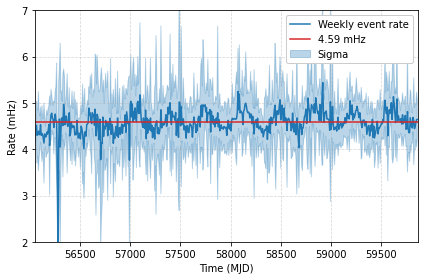

In [113]:
time_data_mjd = grl['start']  # Array mit Zeitdaten in MJD
events_data = grl['events']   # Array mit Anzahl der Ereignisse entsprechend den Zeitdaten
timeintervall = grl['livetime']

#Sort
#time_data_days = time_data_mjd - np.min(time_data_mjd)  # Set time series to 0
sorted_indices = np.argsort(time_data_mjd)
time = time_data_mjd[sorted_indices]
event = events_data[sorted_indices]
intervall = timeintervall[sorted_indices]

# Determine the number of bins
time_window = 7 #days
num_bins = int(np.ceil((time[-1] - time[0]) / time_window))

# Bin data
time_bin_edges = np.linspace(time[0], time[-1], num_bins + 1)
digitized = np.digitize(time, time_bin_edges)
event_per_day = event / (intervall * 24 * 60 * 60)

# Calculate averages and standard deviations. Should be redone with percentiles
time_average = np.array([np.mean(time[digitized == i]) if np.any(digitized == i) else np.nan for i in range(1, num_bins + 1)])
event_average = np.array([np.mean(event_per_day[digitized == i]) if np.any(digitized == i) else np.nan for i in range(1, num_bins + 1)]) * 1000
event_sigma = np.array([np.std(event_per_day[digitized == i]) if np.any(digitized == i) else np.nan for i in range(1, num_bins + 1)]) * 1000

# Calculate lower and upper bounds
y_lower = event_average - event_sigma
y_upper = event_average + event_sigma

plt.figure()
plt.plot(time_average,event_average,label="Weekly event rate")
plt.fill_between(time_average, y_lower, y_upper, alpha=0.3, label='Sigma', color='C0')
plt.axhline(np.nanmean(event_average),color ="C3",label=r"%1.2f mHz"%(np.nanmean(event_average)))

#information
plt.xlabel("Time (MJD)")
plt.ylabel("Rate (mHz)")#(10⁻³ 1/s)
plt.legend(framealpha=1,fancybox=True)

#axis
plt.xlim(min(time),max(time))
plt.ylim(2,7)
plt.grid(lw=0.75,ls='--',alpha=0.5)

plt.tight_layout()
plt.savefig(plotfolder+"3_7dayAverageRate_Greco.pdf")
plt.show()

# Energy

Look at energy distributions
1) Compare true vs reco
2) 1D histograms with the final goal to compare them to the background.
<font color='red'>Question:</font> How can we obtain the background energy distribution (for greco)?

## True vs reconstructed

In [61]:
def PlotTrueVsRecoEnergies(true_energy,reco_energy,weighting,tag):
    '''Plots a 2D histogram of true and reconstructed energy'''
    
    binning=np.logspace(0,3,50)
    
    ax = plt.figure(figsize=(5,3.5))
    h = plt.hist2d(true_energy, reco_energy, bins=binning, cmap='Blues', weights=weighting)#, norm=LogNorm()
    cbar = plt.colorbar(h[3], label=r'ow $\cdot$ $E_{true}^{-2.5}$')# norm=LogNorm()
    
    #add information
    plt.xlabel('True energy (TeV)')
    plt.ylabel('Reconstructed energy (TeV)')
    plt.title(tag)
    
    #make it pretty
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(10**0,5*10**2)
    plt.ylim(10**0,7*10**2)
    plt.plot([0, 500], [0, 500], c='black')
    plt.grid(lw=0.75,ls='--',alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(plotfolder+"4Energy_%s.pdf"%tag)
    plt.show()

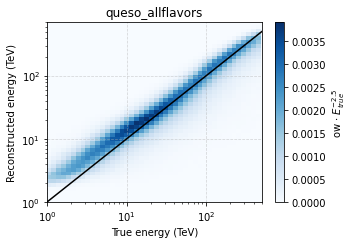

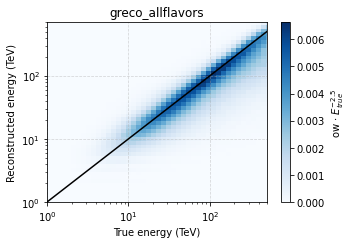

In [62]:
data = queso_all
true_energy = data['trueE']
weights = data['ow'] * true_energy**(-2.5)
reco_energy = data['graphnet_dynedge_energy_reconstruction_energy_pred']
PlotTrueVsRecoEnergies(true_energy,reco_energy,weights,"queso_allflavors")

data = greco_all
true_energy = data['trueE']
weights = data['ow'] * true_energy**(-2.5)
reco_energy = 10**data['logE'] 
PlotTrueVsRecoEnergies(true_energy,reco_energy,weights,"greco_allflavors")

## 1D energy distributions

Recreating plots like this https://wiki.icecube.wisc.edu/index.php/IceCube_Upgrade_Oscillations_2023_Public_Plots#Final_Level_Sample_1d_Distributions

but weight with data["ow"]*data["trueE"]**(-2.5) for comparison with greco files


<font color='red'>Question:</font> The units on the y-axis are still incorrect. How does one correctly convert from a weighted flux to a rate conversion (usi?

### Queso

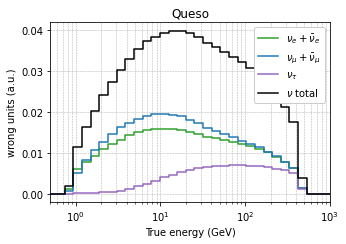

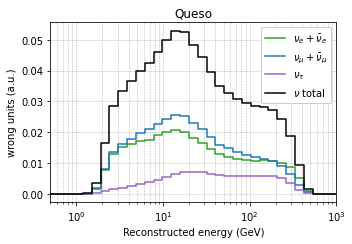

In [116]:
# Define histogram parameters
energy_range = (1e-1, 1e4)  # Set the range for the histogram in log scale
bin_resolution = 0.1  # Set the bin width in log scale
binning=np.logspace(np.log10(energy_range[0]), np.log10(energy_range[1]), int((np.log10(energy_range[1]) - np.log10(energy_range[0])) / bin_resolution))

labels = [r'$\nu_e + \bar{\nu}_e$', r'$\nu_\mu + \bar{\nu}_\mu$', r'$\nu_\tau$', r'$\nu$ total']
colors = ['tab:green','tab:blue','tab:purple','black']

#True energy
ax = plt.figure(figsize=(5,3.5))

files = [queso_e,queso_mu,queso_tau,queso_all]
for data,tag,c in zip(files,labels,colors):
    te = data["trueE"] 
    #w = data["atmo_weight"] #/ 1000
    w = data["ow"]*data["trueE"]**(-2.5)
    
    hist, bin_edges = np.histogram(te, bins=binning,weights=w)
    plt.step(bin_edges[:-1], hist, where='mid',c=c, label=tag)

plt.xlim(0.5,1e3)
#plt.ylim(0,5)
plt.xscale('log')
plt.xlabel('True energy (GeV)')
plt.ylabel('wrong units (a.u.)')
plt.title("Queso")
plt.legend(fancybox=True,framealpha=1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(plotfolder+"4Energy_1D_distributions_queso_True.pdf")
plt.show()


#Reconstructed energy
ax = plt.figure(figsize=(5,3.5))

files = [queso_e,queso_mu,queso_tau,queso_all]
for data,tag,c in zip(files,labels,colors):
    re = data["graphnet_dynedge_energy_reconstruction_energy_pred"]
    #w = data["atmo_weight"] #/ 1000
    w = data["ow"]*data["trueE"]**(-2.5)
    
    hist, bin_edges = np.histogram(re, bins=binning,weights=w)
    plt.step(bin_edges[:-1], hist, where='mid',c=c, label=tag)

plt.xlim(0.5,1e3)
#plt.ylim(0,5)
plt.xscale('log')
plt.xlabel('Reconstructed energy (GeV)')
plt.ylabel('wrong units (a.u.)')
plt.title("Queso")
plt.legend(fancybox=True,framealpha=1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(plotfolder+"4Energy_1D_distributions_queso_Reco.pdf")
plt.show()

## Greco

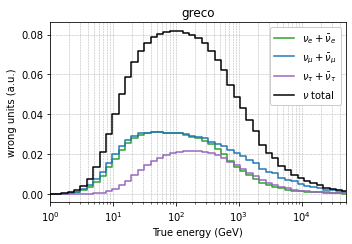

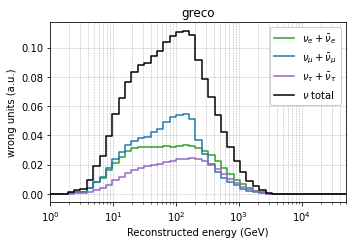

In [117]:
# Define histogram parameters
energy_range = (1e-1, 1e5)  # Set the range for the histogram in log scale
bin_resolution = 0.1  # Set the bin width in log scale
binning=np.logspace(np.log10(energy_range[0]), np.log10(energy_range[1]), int((np.log10(energy_range[1]) - np.log10(energy_range[0])) / bin_resolution))

labels = [r'$\nu_e + \bar{\nu}_e$', r'$\nu_\mu + \bar{\nu}_\mu$', r'$\nu_\tau + \bar{\nu}_\tau$', r'$\nu$ total']
colors = ['tab:green','tab:blue','tab:purple','black']

#True energy
ax = plt.figure(figsize=(5,3.5))

files = [greco_e,greco_mu,greco_tau,greco_all]
for data,tag,c in zip(files,labels,colors):
    te = data["trueE"] 
    #w = data["atmo_weight"] #/ 1000
    w = data["ow"]*data["trueE"]**(-2.5)
    
    hist, bin_edges = np.histogram(te, bins=binning,weights=w)
    plt.step(bin_edges[:-1], hist, where='mid',c=c, label=tag)

plt.xlim(1,5e4)
#plt.ylim(0,5)
plt.xscale('log')
plt.xlabel('True energy (GeV)')
plt.ylabel('wrong units (a.u.)')
plt.title("greco")
plt.legend(fancybox=True,framealpha=1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(plotfolder+"4Energy_1D_distributions_greco_True.pdf")
plt.show()


#Reconstructed energy
ax = plt.figure(figsize=(5,3.5))

files = [greco_e,greco_mu,greco_tau,greco_all]
for data,tag,c in zip(files,labels,colors):
    re = 10**data["logE"]
    #w = data["atmo_weight"] #/ 1000
    w = data["ow"]*data["trueE"]**(-2.5)
    
    hist, bin_edges = np.histogram(re, bins=binning,weights=w)
    plt.step(bin_edges[:-1], hist, where='mid',c=c, label=tag)

plt.xlim(1,5e4)
#plt.ylim(0,0.15)
plt.xscale('log')
plt.xlabel('Reconstructed energy (GeV)')
plt.ylabel('wrong units (a.u.)')
plt.title("greco")
plt.legend(fancybox=True,framealpha=1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(plotfolder+"4Energy_1D_distributions_greco_Reco.pdf")
plt.show()

### Difference True-Reco comparison

I just played around, this is probably dumb

In [76]:
def EnergyHisto_1D_diff(diff1,diff2,w1,w2,tag,showplot=True):
    '''Plots a 1D histogram of difference between true - reconstructed energy and compares two datasets.'''
    
    # Define histogram parameters
    #energy_range = (1e-1, 1e4)  # Set the range for the histogram in log scale
    #bin_resolution = 0.1  # Set the bin width in log scale
    #binning=np.logspace(np.log10(energy_range[0]), np.log10(energy_range[1]), int((np.log10(energy_range[1]) - np.log10(energy_range[0])) / bin_resolution))
    binning=np.linspace(-500,500,100)
    
    # Create histogram
    hist1, bin_edges1 = np.histogram(diff1, bins=binning,weights=w1)
    hist2, bin_edges2 = np.histogram(diff2, bins=binning,weights=w2)
    
    ax = plt.figure(figsize=(5,3.5))
    plt.step(bin_edges1[:-1], hist1, where='mid', color='tab:blue', alpha=0.7, label='Queso')
    plt.step(bin_edges2[:-1], hist2, where='mid', color='tab:orange', alpha=0.7, label='Greco')

    #plt.xlim(1,500)
    #plt.ylim(1e-5,1e-1)
    #plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Misreconstructed energy (GeV)')
    plt.ylabel('Events per energy bin (a.u.)')
    plt.title(tag)
    plt.legend(fancybox=True,framealpha=1)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.savefig(plotfolder+"4Energy_1D_distributions_%s.pdf"%tag)
    plt.show()

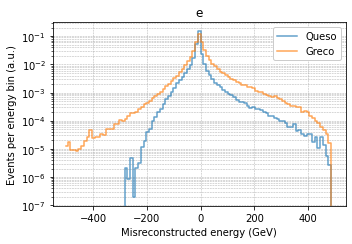

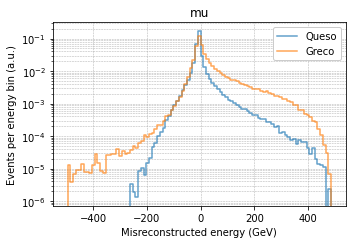

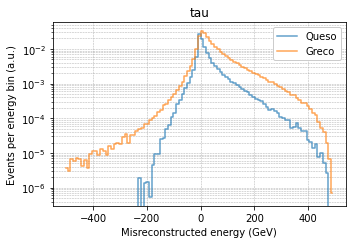

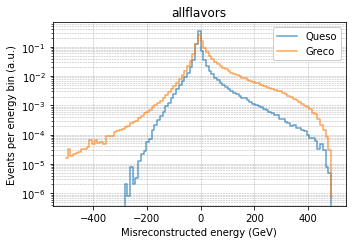

In [78]:
queso_files = [queso_e, queso_mu, queso_tau, queso_all] #needs to be first argument for label
greco_files = [greco_e, greco_mu, greco_tau, greco_all] #needs to be 2nd argument for label (I was lazy)
labels = ['e', 'mu', 'tau', 'allflavors']

for queso_data, greco_data, label in zip(queso_files, greco_files, labels):
    # Process queso data
    mask1 = queso_data['trueE'] < 500
    true_energy1 = queso_data['trueE'][mask1]
    reco_energy1 = queso_data['graphnet_dynedge_energy_reconstruction_energy_pred'][mask1]
    weights1 = queso_data['ow'][mask1] * queso_data['trueE'][mask1]**(-2.5)

    # Process greco data
    mask2 = greco_data['trueE'] < 500
    true_energy2 = greco_data['trueE'][mask2]
    reco_energy2 = 10**greco_data['logE'][mask2]
    weights2 = greco_data['ow'][mask2] * greco_data['trueE'][mask2]**(-2.5)

    # Generate plots
    EnergyHisto_1D_diff(true_energy1 - reco_energy1, true_energy2 - reco_energy2, weights1, weights2, label)
